       
# Final Project 4

In this project the final model creation will be done with comparisons of performance and analyzing the outcome of it 

### Step 1: Loading the python libraries needed for this project 

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from os import system 
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search

from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus ## Install with `conda install pydotplus`, if necessary

%matplotlib inline

### Step 2: Reading the data set 

In [3]:
#Read in data from source 
df_raw = pd.read_csv("./datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = df_raw.copy()
print(df_raw.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...   DeviceProtection  \
0  No phone service             DSL             No  ...                 No   
1                No             DSL            Yes  ...                Yes   
2                No             DSL            Yes  ...                 No   
3  No phone service             DSL            Yes  ...                Yes   
4                No     Fiber optic             No  ...                 No   

  TechSupport StreamingTV StreamingMovies        C

### Step 3: Pre-processing

In [5]:
for col in ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']:
     df_raw[col].replace({'Yes': 1, 'No': 0}, inplace=True)

In [6]:
for col in ['MultipleLines']:
     df_raw[col].replace({'Yes': 1, 'No': 0, 'No phone service': 2}, inplace=True)

In [7]:
for col in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
     df_raw[col].replace({'Yes': 1, 'No': 0, 'No internet service': 2}, inplace=True)

In [8]:
df_raw['gender']=df_raw['gender'].replace({'Male': 0, 'Female': 1})
df_raw['InternetService']=df_raw['InternetService'].replace({'DSL': 0, 'Fiber optic': 1, 'No': 2})
df_raw['Contract']=df_raw['Contract'].replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df_raw['PaymentMethod']=df_raw['PaymentMethod'].replace({'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)':3})

From the dataset and from the previous analisys it could be studied the correlation between variables and which features are important to analyze in this matter. 

The correlation study will be included below:

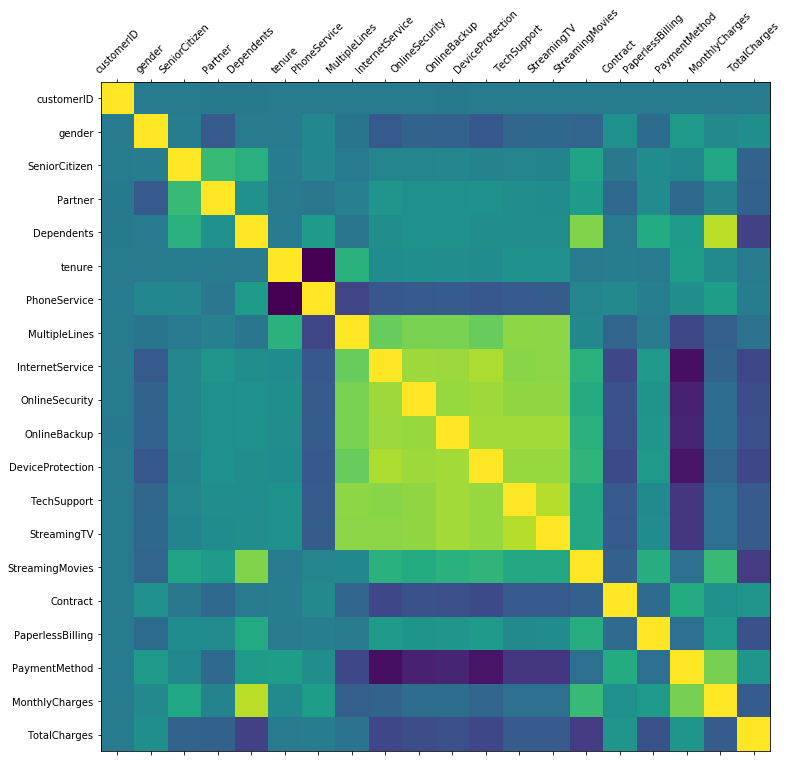

In [9]:
#plt.matshow(df_raw.corr())

# Try this:
plt.figure(figsize=(12,12))
ax = plt.matshow(df_raw.corr(), fignum=1)
plt.xticks(rotation=45)
ax.axes.set_xticklabels(['']+df_raw.columns.tolist())
ax.axes.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.axes.set_yticklabels(['']+df_raw.columns.tolist())
ax.axes.yaxis.set_major_locator(plt.MultipleLocator(1))

Coming from the results of the matrix of correlation is where we can start drawing conclusions about which variables we dont need to account in order to avoid multicollinearity.     

In [10]:
#Convert 'M'/'F' to 1/0
df['gender']=df['gender'].replace({'Male': 0, 'Female': 1})

# Converting binary variables from strings to numbers
for col in ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']:
     df[col].replace({'Yes': 1, 'No': 0}, inplace=True)

In [9]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,0,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,0,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,0,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,1,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


Droppping the columns that are not going to be used to avoid multicollinearity, the binary features were transformed in a previous step

In [10]:
df=df[['gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','InternetService','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','Churn']]
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,1,0,1,0,1,0,DSL,Month-to-month,1,Electronic check,29.85,0
1,0,0,0,0,34,1,DSL,One year,0,Mailed check,56.95,0
2,0,0,0,0,2,1,DSL,Month-to-month,1,Mailed check,53.85,1
3,0,0,0,0,45,0,DSL,One year,0,Bank transfer (automatic),42.30,0
4,1,0,0,0,2,1,Fiber optic,Month-to-month,1,Electronic check,70.70,1


Now the dummy variables will be created from the features 'InternetService','Contract' and 'PaymentMethod'     


In [13]:
# Transform dummy vars with specified prefixes
dummy_IntServ = pd.get_dummies(df['InternetService'], prefix='IntServ')
dummy_Contract = pd.get_dummies(df['Contract'], prefix='Contract')
dummy_PayMethod = pd.get_dummies(df['PaymentMethod'], prefix='PayMethod')
dummy_Contract = pd.get_dummies(df['Contract'], prefix='Contract')

# Print 5 examples
print(dummy_IntServ.head())
#print(dummy_Contract.head())
#print(dummy_PayMethod.head())
#print(dummy_Contract.head())

   IntServ_DSL  IntServ_Fiber optic  IntServ_No
0            1                    0           0
1            1                    0           0
2            1                    0           0
3            1                    0           0
4            0                    1           0


The columns that will be chosen for the model will be selected here and the dummy variables in the way (n-1) will be added to it

In [18]:
cols_to_keep = ['Churn','gender', 'SeniorCitizen', 'Partner','Dependents','tenure','PhoneService','PaperlessBilling','MonthlyCharges']
data = df[cols_to_keep].join(dummy_IntServ.loc[:, 'IntServ_Fiber Optic':])
data = data.join(dummy_Contract.loc[:, 'Contract_One year':])
data = data.join(dummy_PayMethod.loc[:, 'PayMethod_Credit card (automatic)':])

print(data.head())

   Churn  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0      0       1              0        1           0       1             0   
1      0       0              0        0           0      34             1   
2      1       0              0        0           0       2             1   
3      0       0              0        0           0      45             0   
4      1       1              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  IntServ_Fiber optic  IntServ_No  \
0                 1           29.85                    0           0   
1                 0           56.95                    0           0   
2                 1           53.85                    0           0   
3                 0           42.30                    0           0   
4                 1           70.70                    1           0   

   Contract_One year  Contract_Two year  PayMethod_Credit card (automatic)  \
0                  0

### Step 4: Modeling with Decision Trees and Random Forests

#### Define the labels of the covariates (columns) as a variable called 'train_cols'

In [90]:
train_cols = data.columns[1:]
print(train_cols.values)
# train_cols
# ##Index([u'gender', u'SeniorCitizen', u'Partner', u'Dependents', u'tenure',
#  #      u'PhoneService', u'PaperlessBilling', u'MonthlyCharges',
#  #      u'IntServ_Fiber optic', u'IntServ_No', u'Contract_One year',
#  #      u'Contract_Two year', u'PayMethod_Credit card (automatic)',
#  #      u'PayMethod_Electronic check', u'PayMethod_Mailed check', u'intercept'],
#  #     dtype='object')

['gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure' 'PhoneService'
 'PaperlessBilling' 'MonthlyCharges' 'IntServ_Fiber optic' 'IntServ_No'
 'Contract_One year' 'Contract_Two year'
 'PayMethod_Credit card (automatic)' 'PayMethod_Electronic check'
 'PayMethod_Mailed check' 'intercept']


In [91]:
#creating decision tree model
model = DecisionTreeClassifier()

X = data[train_cols]
y = data['Churn']
    
# Fit the model
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [92]:
# use cross_val_score()

# ... #

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.65698138 0.67204963 0.65062432 0.63819669 0.67388475], Average AUC 0.658347354168


So the model score is 0.65

In [93]:
zipped = zip(*[X.columns,model.feature_importances_])
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)

for a in zipped:
    print(a)
    
top_features = [i[0] for i in zipped][:5]

print('')
print('Using only these features: '+str(top_features))

('MonthlyCharges', 0.3415488799352737)
('tenure', 0.2997808170481723)
('IntServ_Fiber optic', 0.10756628694688723)
('gender', 0.04105197501516411)
('Partner', 0.03493677956027811)
('PaperlessBilling', 0.027037808679474022)
('PayMethod_Electronic check', 0.026883801862763467)
('Dependents', 0.023452683853782182)
('SeniorCitizen', 0.020325115248816642)
('PayMethod_Credit card (automatic)', 0.019224816553572447)
('PayMethod_Mailed check', 0.015028809894744017)
('Contract_One year', 0.014099865120881537)
('IntServ_No', 0.012071007466289014)
('Contract_Two year', 0.010648833663490804)
('PhoneService', 0.006342519150410469)
('intercept', 0.0)

Using only these features: ['MonthlyCharges', 'tenure', 'IntServ_Fiber optic', 'gender', 'Partner']


In [94]:
# Re-fit the model with fewer features
X_top = X[top_features]

model.fit(X_top, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [95]:
# use cross_val_score()

# ... #

scores = cross_val_score(model, X_top, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.66344327 0.6510061  0.64201407 0.62980351 0.64716862], Average AUC 0.646687114314


The model score is 0.64, which is 0.1 less than the previous, so having less variables didnt product any big changes in the effectiveness of it 

In [80]:
# Helper function to visualize Decision Trees (creates a file tree.png)
def build_tree_image(model):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model, out_file = dotfile, feature_names = X.columns,
                   filled=True, rounded=True)

    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

In [79]:
# Helper function to visualize Decision Trees (shows tree inline)
def build_tree_inline(model):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, feature_names=X.columns,  
                filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    Image(graph.create_png())
    
build_tree_inline(model)

### Adjusting Decision Trees to Avoid Overfitting

In [78]:
#creating the model 
model = DecisionTreeClassifier(
                max_depth = 4,
                min_samples_leaf = 3)

model.fit(X, y)
build_tree_image(model)
build_tree_inline(model)

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.82466183 0.83316725 0.79964125 0.81290159 0.82014413], Average AUC 0.818103207954


The model score is 0.81 which is higher than the previous, in this case due to the fact that we avoid overfitting. And also considering that we were using the same number of variables 

### Random Forest Models

In [69]:
#creating the model 
model = RandomForestClassifier(n_estimators = 10)

model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
# use cross_val_score()

# ... #

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.76127498 0.76242164 0.74947974 0.73030925 0.75733628], Average AUC 0.752164377922


This result is lower than the adjusted decision tree 

In [71]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
0,MonthlyCharges,0.556003
1,tenure,0.340655
2,IntServ_Fiber optic,0.070343
4,Partner,0.020768
3,gender,0.012230


In [76]:
scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 250, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [0.78716087 0.78344928 0.77099199], Average AUC 0.780534044406
n trees: 1, CV AUC [0.65902836 0.66632375 0.64249713], Average AUC 0.655949746141
n trees: 11, CV AUC [0.77125034 0.76911964 0.74797772], Average AUC 0.762782566036
n trees: 21, CV AUC [0.7749055  0.77169196 0.76246266], Average AUC 0.769686704602
n trees: 31, CV AUC [0.7777856  0.77959173 0.76894336], Average AUC 0.77544023113
n trees: 41, CV AUC [0.78713802 0.78051695 0.77284848], Average AUC 0.780167813393
n trees: 51, CV AUC [0.78365913 0.780821   0.7696009 ], Average AUC 0.778027009693
n trees: 61, CV AUC [0.78648421 0.77889689 0.77186544], Average AUC 0.779082177825
n trees: 71, CV AUC [0.78332663 0.77954603 0.77066322], Average AUC 0.777845293201
n trees: 81, CV AUC [0.78925239 0.78057943 0.77290304], Average AUC 0.780911622985
n trees: 91, CV AUC [0.78706667 0.77916456 0.77020574], Average AUC 0.778812323394
n trees: 101, CV AUC [0.78565086 0.78103505 0.77356431], Average AUC 0.78008340616
n trees: 111, CV AU

We can see that the score is going up but we will require +250 trees to achieve a better score closer to the one already obtained above 

In [77]:
#grid_search 
n_trees = range(1, 100, 10)
gs = grid_search.GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={'n_estimators': n_trees},
    scoring='roc_auc')

gs.fit(X, y)

print(gs.param_grid) # Parameter space explored
print(gs.best_score_) # Best 'neg_mean_squared_error'
print(gs.best_estimator_) # Best combination of paramaters

{'n_estimators': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91]}
0.781628074063
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Even though grid search scores high is not as high as the decision tree 

### Step 5: Modeling with Logistic Regression
We're going to add a constant term for our Logistic Regression
- The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly

In [96]:
# manually add the intercept
data['intercept'] = 1.0

#### Fit the model

The features that will be used in this case will be the top features found in the decision tree model. 

In [97]:
logit = sm.Logit(data['Churn'], X_top)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.459545
         Iterations 6


#### Print the summary results

In [98]:
print(result.summary2())

                           Results: Logit
Model:                Logit             No. Iterations:    6.0000   
Dependent Variable:   Churn             Pseudo R-squared:  0.206    
Date:                 2018-05-15 22:25  AIC:               6473.0348
No. Observations:     7032              BIC:               6507.3259
Df Model:             4                 Log-Likelihood:    -3231.5  
Df Residuals:         7027              LL-Null:           -4071.7  
Converged:            1.0000            Scale:             1.0000   
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
MonthlyCharges      -0.0051   0.0014  -3.8050 0.0001 -0.0078 -0.0025
tenure              -0.0477   0.0017 -27.3001 0.0000 -0.0512 -0.0443
IntServ_Fiber optic  1.7902   0.1019  17.5618 0.0000  1.5904  1.9900
gender              -0.2358   0.0587  -4.0198 0.0001 -0.3507 

#### Calculate the odds ratio of the coefficients and their 95% [confidence intervals]
    

In [103]:
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf)) # confidence intervals (we get the odds ratio from the log odds by exponentiating the coefficient)

                         2.5%     97.5%        OR
MonthlyCharges       0.992234  0.997508  0.994867
tenure               0.950114  0.956650  0.953376
IntServ_Fiber optic  4.905859  7.315690  5.990805
gender               0.704160  0.886190  0.789949
Partner              0.708760  0.915850  0.805679
